# Chapter 5

In [1]:
from PIL import Image
import webgpupy as np

In [2]:
class Vec3:
    def __new__(cls, x=0.0, y=0.0, z=0.0):
        return np.array([x, y, z])

Point3=Vec3
Color=Vec3

In [3]:
class VecUtils:
    @staticmethod
    def x(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,0].reshape((image_height, image_width, 1))

    @staticmethod
    def y(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,1].reshape((image_height, image_width, 1))
    
    @staticmethod
    def z(data):
        image_height = data.shape[0]
        image_width = data.shape[1]
        return data[:,:,2].reshape((image_height, image_width, 1))

    @staticmethod
    def unit_vector(data):
        e0 = VecUtils.x(data)
        e1 = VecUtils.y(data)
        e2 = VecUtils.z(data)
        return data / np.sqrt((e0*e0+e1*e1+e2*e2))
    
    @staticmethod
    def dot(data1, data2):
        data1_x = VecUtils.x(data1)
        data1_y = VecUtils.y(data1)
        data1_z = VecUtils.z(data1)
        data2_x = VecUtils.x(data2)
        data2_y = VecUtils.y(data2)
        data2_z = VecUtils.z(data2)
        return data1_x * data2_x + data1_y * data2_y + data1_z * data2_z

In [4]:
class Rays:
    
    def __init__(self, origin, direction) -> None:
        self.orig = origin
        self.dir = direction

    def origin(self):
        return self.orig

    def direction(self):
        return self.dir

    def at(self, t):
        return self.orig + t*self.dir


In [5]:
def convert_to_image(pixels):
    print(pixels.shape)
    pixels = (pixels * 255.0).astype('uint8')
    import numpy
    image_array = numpy.array(pixels.tolist(), dtype= 'uint8')
    return Image.fromarray(image_array, 'RGB')

def hit_sphere(center, radius, r: Rays):
    oc = r.origin() - center
    a = VecUtils.dot(r.direction(), r.direction())
    b = 2.0 * VecUtils.dot(oc, r.direction())
    c = VecUtils.dot(oc, oc) - radius*radius
    discriminant = b*b - 4.0*a*c
    return (discriminant > 0.0)

def ray_color(r: Rays):
    is_hit = hit_sphere(Point3(0.0,0.0,-1.0), 0.5, r)
    hit_color = is_hit.astype('float32') * Color(1.0, 0.0, 0.0)
    dir = r.direction()
    unit_direction = VecUtils.unit_vector(dir)
    t = 0.5*(VecUtils.y(unit_direction) + 1.0)
    is_not_hit = np.invert(is_hit)
    is_not_hit_color = ((1.0-t)*Color(1.0, 1.0, 1.0) + t*Color(0.5, 0.7, 1.0)) * is_not_hit.astype('float32')
    return hit_color+is_not_hit_color

[720, 1280, 3]


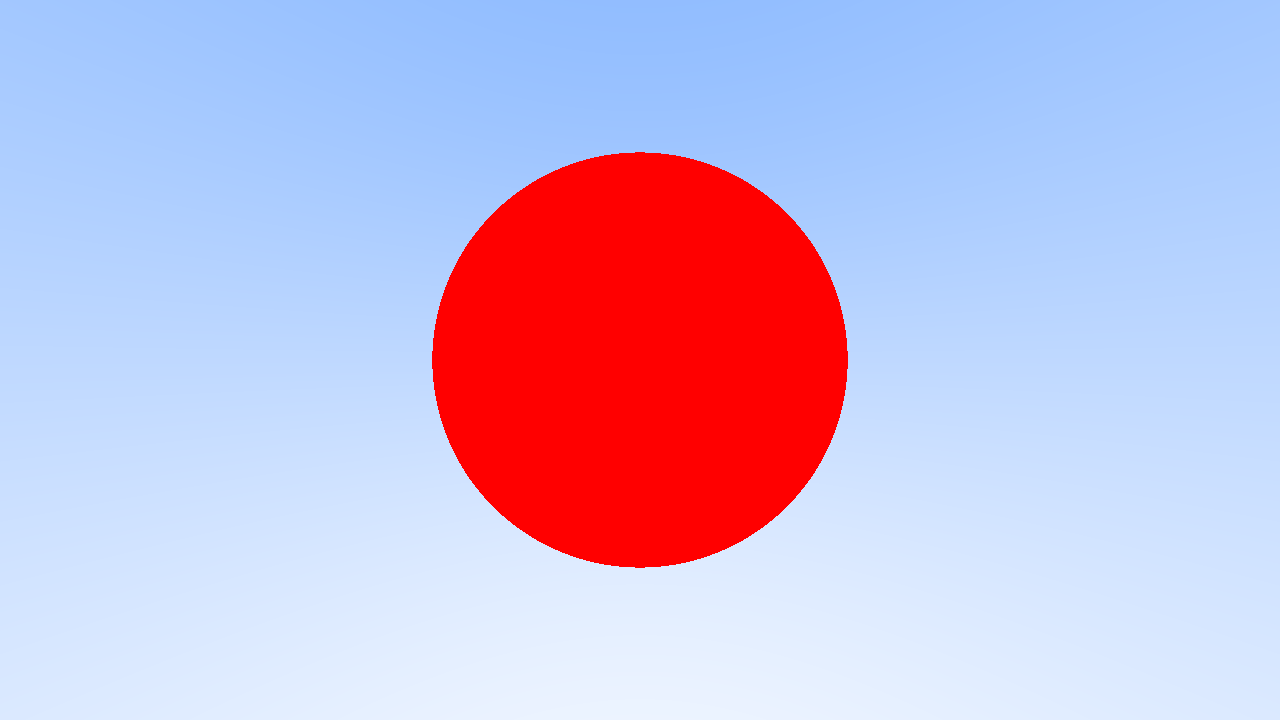

In [7]:
image_height = 720
aspect_ratio = 16/9
image_width = int(image_height * aspect_ratio)

viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

origin = Point3(0.0, 0.0, 0.0)
horizontal = Vec3(viewport_width, 0.0, 0.0)
vertical = Vec3(0.0, viewport_height, 0.0)
lower_left_corner = origin - horizontal/2.0 - vertical/2.0 - Vec3(0.0, 0.0, focal_length)
origin = np.broadcast_to(origin, (image_height, image_width, 3))

u = np.array([[i/(image_width - 1) for i in range(0, image_width)]])
u = np.repeat(u, image_height, axis=0).reshape([image_height, image_width, 1])
v = np.array([i/(image_height - 1) for i in range(image_height-1, -1, -1)]).reshape([image_height, 1])
v = np.repeat(v, image_width, axis=1).reshape([image_height, image_width, 1])

direction = lower_left_corner + u*horizontal + v*vertical - origin
rays = Rays(origin, direction)
pixels = ray_color(rays)
convert_to_image(pixels)